In [ ]:
# Instalando a biblioteca PYOMO
!pip install pyomo

# Instalando a biblioteca GLPK (problemas de otimizacao linear)
!apt-get install -y -qq glpk-utils

# Instalando a biblioteca IDAEs e IPOT (problemas de otimizacao nao-linear e EDPs)
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()

Referencias:

[Pyomo Colab 01.01](https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/01.02-Running-Pyomo-on-Google-Colab.ipynb#scrollTo=HsTASLpi8sdg)

[Pyomo Colab 01.00](https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/01.00-Pyomo-Introduction.ipynb#scrollTo=-TJjfEDLcM0t)

[DataCamp - Tutorial Pyomo](https://www.datacamp.com/tutorial/pyomo)

[Exemplos Github Pyomo](https://github.com/Pyomo/pyomo/tree/main/examples)

## Problema de Otimizacao Linear


In [2]:
import pyomo.environ as pyo
# Create a model
model = pyo.ConcreteModel()
# Define variables
model.x = pyo.Var(within=pyo.NonNegativeReals)
model.y = pyo.Var(within=pyo.NonNegativeReals)
# Define objective
model.obj = pyo.Objective(expr=model.x + model.y, sense=pyo.minimize)
# Define constraints
model.con1 = pyo.Constraint(expr=model.x + 2 * model.y >= 4)
model.con2 = pyo.Constraint(expr=model.x - model.y <= 1)
# Select solver
solver = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model).write()
# Solve the problem
print('\nProfit = ', model.obj())

# result = solver(model)
# # Display results
# print('Status:', result.solver.status)
# print('Termination Condition:', result.solver.termination_condition)
print('Optimal x:', pyo.value(model.x))
print('Optimal y:', pyo.value(model.y))
# print('Optimal Objective:', pyo.value(model.obj))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2.0
  Upper bound: 2.0
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 2
  Number of nonzeros: 4
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.01524972915649414
# ----------------------------------------------------------
#   Solution Information
# -----------------------------------------

# Problema de Otimizacao Nao Linear

In [3]:
import pyomo.environ as pyo
model = pyo.ConcreteModel()
# Define variables with lower bounds
model.x = pyo.Var(bounds=(0, None))
model.y = pyo.Var(bounds=(0, None))
# Objective function: minimize (x - 1)² + (y - 2)²
model.obj = pyo.Objective(expr=(model.x - 1)**2 + (model.y - 2)**2, sense=pyo.minimize)
# Constraint: x² + y² ≤ 5 (circle of radius 2)
model.circle = pyo.Constraint(expr=model.x**2 + model.y**2 <= 5)
solver = pyo.SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
#result = solver.solve(model)
print('Optimal x:', pyo.value(model.x))
print('Optimal y:', pyo.value(model.y))
print('Minimum Z:', pyo.value(model.obj))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 2
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.017664432525634766
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Optimal

# Problema de Controle Otimo

preferred method of obtaining a component name is to use the     .name
property, which returns the fully qualified component name.     The
.local_name property will return the component name only within
the context of the immediate parent container.  (deprecated in 5.0)
(called from <ipython-input-4-9930092a82ad>:76)
preferred method of obtaining a component name is to use the     .name
property, which returns the fully qualified component name.     The
.local_name property will return the component name only within
the context of the immediate parent container.  (deprecated in 5.0)
(called from <ipython-input-4-9930092a82ad>:77)


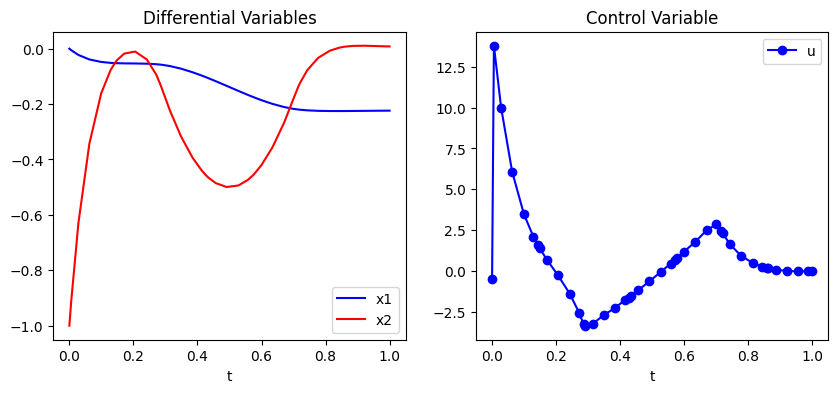

In [4]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar

model = m = pyo.ConcreteModel()
m.tf = pyo.Param(initialize = 1)
m.t = ContinuousSet(bounds=(0, m.tf))
m.u = pyo.Var(m.t, initialize=0)
m.x1 = pyo.Var(m.t)
m.x2 = pyo.Var(m.t)
m.x3 = pyo.Var(m.t)
m.dx1dt = DerivativeVar(m.x1, wrt=m.t)
m.dx2dt = DerivativeVar(m.x2, wrt=m.t)
m.dx3dt = DerivativeVar(m.x3, wrt=m.t)
m.obj = pyo.Objective(expr=m.x3[m.tf])

def _x1dot(m, t):
  return m.dx1dt[t] == m.x2[t]
m.x1dot = pyo.Constraint(m.t, rule=_x1dot)

def _x2dot(m, t):
  return m.dx2dt[t] == -m.x2[t] + m.u[t]
m.x2dot = pyo.Constraint(m.t, rule=_x2dot)

def _x3dot(m, t):
  return m.dx3dt[t] == m.x1[t]**2 + \
m.x2[t]**2 + 0.005*m.u[t]**2
m.x3dot = pyo.Constraint(m.t, rule=_x3dot)

def _con(m, t):
  return m.x2[t] - 8*(t-0.5)**2 + 0.5 <= 0
m.con = pyo.Constraint(m.t, rule=_con)

def _init(m):
  yield m.x1[0] == 0
  yield m.x2[0] == -1
  yield m.x3[0] == 0

m.init_conditions = pyo.ConstraintList(rule=_init)


from pyomo.environ import *
from pyomo.dae import *
#from Optimal_Control import m

# Discretize model using Backward Finite Difference method
# discretizer = TransformationFactory('dae.finite_difference')
# discretizer.apply_to(m,nfe=20,scheme='BACKWARD')

# Discretize model using Orthogonal Collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=7, ncp=6, scheme='LAGRANGE-RADAU')
#discretizer.reduce_collocation_points(m, var=m.u, ncp=1, contset=m.t)

solver = SolverFactory('ipopt', executable='/content/ipopt').solve(m)

#results = solver.solve(m, tee=True)

x1 = []
x2 = []
u = []
t = []

#print(sorted(m.t))

for i in sorted(m.t):
    t.append(i)
    x1.append(value(m.x1[i]))
    x2.append(value(m.x2[i]))
    u.append(value(m.u[i]))

def plotter(subplot, x, *series, **kwds):
  plt.subplot(subplot)
  for i,y in enumerate(series):
    plt.plot(x, [pyo.value(y[t]) for t in x], 'brgcmk'[i%6]+kwds.get('points',''))
    plt.title(kwds.get('title',''))
    plt.legend(tuple(y.cname() for y in series))
    plt.xlabel(x.cname())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))  # Ajuste o tamanho conforme desejado
plotter(121, m.t, m.x1, m.x2, title='Differential Variables')
plotter(122, m.t, m.u, title='Control Variable', points='o-')
plt.show()

# Problema de EDO

In [5]:
from scipy import *

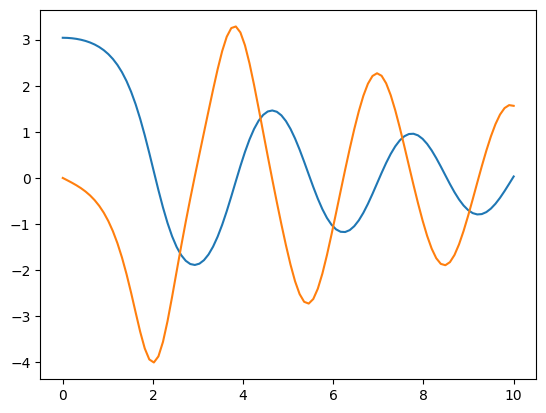

In [6]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from pyomo.dae import ContinuousSet, DerivativeVar
m = model = pyo.ConcreteModel()
m.t = ContinuousSet(bounds=(0.0, 10.0))
m.b = pyo.Param(initialize=0.25)
m.c = pyo.Param(initialize=5.0)
m.theta = pyo.Var(m.t)
m.omega = pyo.Var(m.t)
m.dthetadt = DerivativeVar(m.theta, wrt=m.t)
m.domegadt = DerivativeVar(m.omega, wrt=m.t)
m.theta[0].fix(3.14 - 0.1)
m.omega[0].fix(0.0)

def _diffeq1(m,t):
  return m.dthetadt[t] == m.omega[t]
m.diffeq1 = pyo.Constraint(m.t, rule=_diffeq1)
def _diffeq2(m,t):
  return m.domegadt[t] == -m.b*m.omega[t] - m.c*pyo.sin(m.theta[t])
m.diffeq2 = pyo.Constraint(m.t, rule=_diffeq2)

from pyomo.dae import simulator
mysim = simulator.Simulator(model, package='scipy')
tsim, profiles = mysim.simulate(integrator='vode', numpoints=100)
varorder = mysim.get_variable_order()

for idx, v in enumerate(varorder):
  plt.plot(tsim, profiles[:, idx], label=v)


# Problema de EDP

O problema a ser resolvido tem as seguintes características:

* A Equação Diferencial Parcial (EDP):

$$\pi^2 \dfrac{\partial u}{\partial t} = \dfrac{\partial u}{\partial x^2}$$

* A Condição Inicial:
$$u(x,0) = sin(\pi x)$$

* As Condições de Contorno:
$$u(0,t) = 0 \\ \pi e^{-t} + \dfrac{\partial u}{\partial x}(1,t) = 0 $$

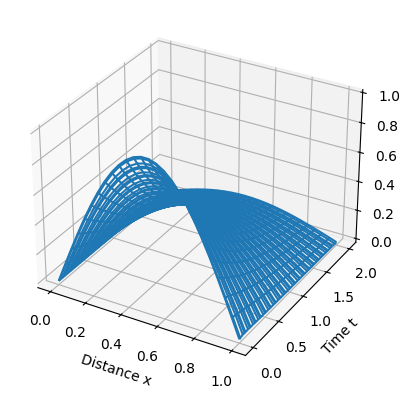

In [7]:
#  ___________________________________________________________________________
#
#  Pyomo: Python Optimization Modeling Objects
#  Copyright (c) 2008-2024
#  National Technology and Engineering Solutions of Sandia, LLC
#  Under the terms of Contract DE-NA0003525 with National Technology and
#  Engineering Solutions of Sandia, LLC, the U.S. Government retains certain
#  rights in this software.
#  This software is distributed under the 3-clause BSD License.
#  ___________________________________________________________________________

# Example 1 from http://www.mathworks.com/help/matlab/ref/pdepe.html

from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()
m.pi = Param(initialize=3.1416)
m.t = ContinuousSet(bounds=(0, 2))
m.x = ContinuousSet(bounds=(0, 1))
m.u = Var(m.x, m.t)

m.dudx = DerivativeVar(m.u, wrt=m.x)
m.dudx2 = DerivativeVar(m.u, wrt=(m.x, m.x))
m.dudt = DerivativeVar(m.u, wrt=m.t)

def _pde(m, i, j):
    if i == 0 or i == 1 or j == 0:
        return Constraint.Skip
    return m.pi**2 * m.dudt[i, j] == m.dudx2[i, j]
m.pde = Constraint(m.x, m.t, rule=_pde)

def _initcon(m, i):
    if i == 0 or i == 1:
        return Constraint.Skip
    return m.u[i, 0] == sin(m.pi * i)
m.initcon = Constraint(m.x, rule=_initcon)

def _lowerbound(m, j):
    return m.u[0, j] == 0
m.lowerbound = Constraint(m.t, rule=_lowerbound)

def _upperbound(m, j):
    return m.pi * exp(-j) + m.dudx[1, j] == 0
m.upperbound = Constraint(m.t, rule=_upperbound)

m.obj = Objective(expr=1)

# Discretize using Orthogonal Collocation
# discretizer = TransformationFactory('dae.collocation')
# discretizer.apply_to(m,nfe=10,ncp=3,wrt=m.x)
# discretizer.apply_to(m,nfe=20,ncp=3,wrt=m.t)

# Discretize using Finite Difference and Collocation
discretizer = TransformationFactory('dae.finite_difference')
discretizer2 = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=25, wrt=m.x, scheme='BACKWARD')
discretizer2.apply_to(m, nfe=20, ncp=3, wrt=m.t)

# Discretize using Finite Difference Method
# discretizer = TransformationFactory('dae.finite_difference')
# discretizer.apply_to(m,nfe=25,wrt=m.x,scheme='BACKWARD')
# discretizer.apply_to(m,nfe=20,wrt=m.t,scheme='BACKWARD')

solver = SolverFactory('ipopt', executable='/content/ipopt').solve(m)
#results = solver.solve(m, tee=True)

x = []
t = []
u = []

for i in sorted(m.x):
    temp = []
    tempx = []
    for j in sorted(m.t):
        tempx.append(i)
        temp.append(value(m.u[i, j]))
    x.append(tempx)
    t.append(sorted(m.t))
    u.append(temp)


import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('Distance x')
ax.set_ylabel('Time t')
p = ax.plot_wireframe(numpy.array(x), numpy.array(t), numpy.array(u), rstride=1, cstride=1)
fig.show()